In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from scipy import linalg as LA

### H5.1: Cross-validation
The file TrainingRidge.csv contains the training set, with 200 observations and corre-
sponding target values (ground truth/labels) {(x(α),y(α))}. The two input variables for each T
observation x(α) = (x(α), x(α))⊤ appear in the first 2 columns. The target values y(α) appear in
the last column.

The data contained in the second file ValidationRidge.csv serves as the validation set.
It follows the same format as above. The validation set contains 1476 pairs {(x(β), y(β))}. The
values of x(β) = (x(β), x(β))⊤ form a 36 × 41 grid in input space.

In [57]:
# sphereing pre-processing functionality 
def PCA(x,**kwargs):
    # regularization parameter for numerical stability
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']

    # create the correlation matrix
    P = float(x.shape[1])
    Cov = 1/P*np.dot(x,x.T) + lam*np.eye(x.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    d,V = np.linalg.eigh(Cov)
    return d,V

# ZCA spherer 
def ZCA_spherer(x,**kwargs):
    # Step 1: mean-center the data
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_centered = x - x_means

    # Step 2: compute pca transform on mean-centered data
    d,V = PCA(x_centered,**kwargs)

    # Step 3: divide off standard deviation of each (transformed) input, 
    # which are equal to the returned eigenvalues in 'd'.  
    stds = (d[:,np.newaxis])**(0.5)

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(stds < 10**(-5))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((stds.shape))
        adjust[ind] = 1.0
        stds += adjust

    # create normalizer / inverse-normalizer
    return np.dot(V,np.dot(V.T,x_centered)/stds)

x_train: (200, 2)
x_centered: (200, 2)
C: (2, 2)
λ: (2, 2)
E: (2, 2)
x_decorrelated: (2, 200)
x_sphered: (2, 200)


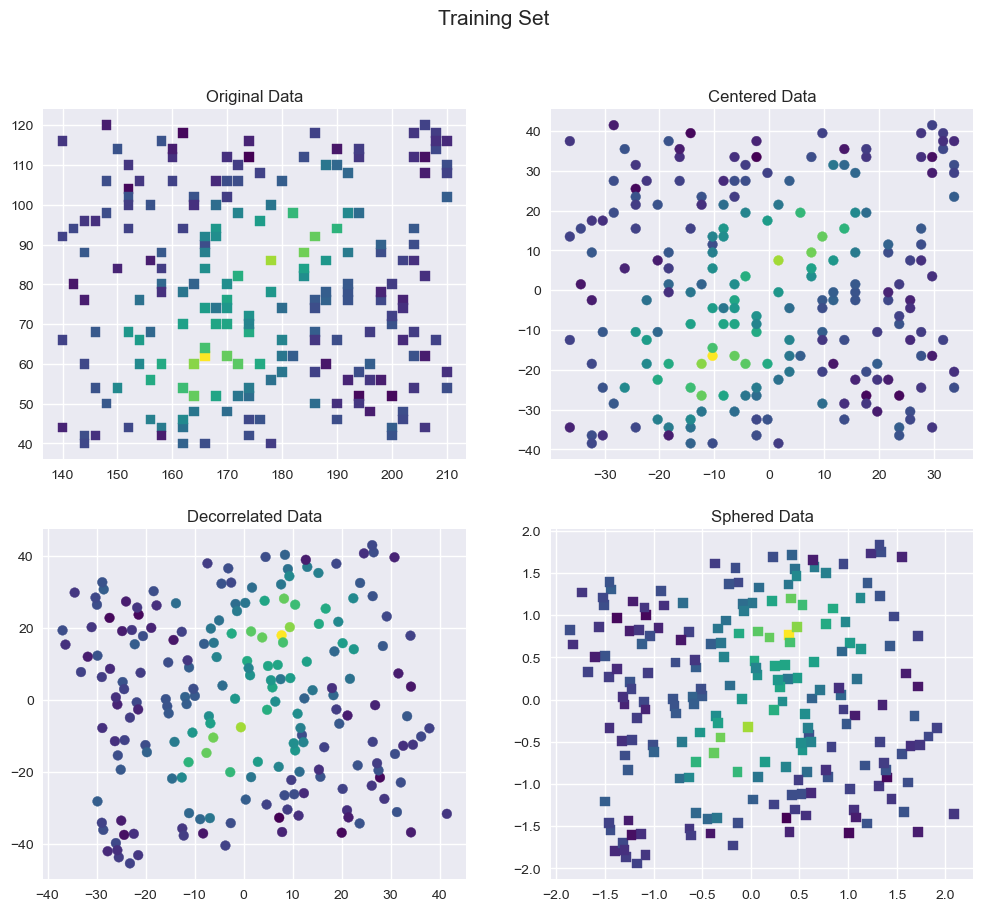

x_sphered mean: [0. 0.]
x_sphered std: [1. 1.]


In [66]:
# Training Set 

data_train = np.genfromtxt('Data/TrainingRidge.csv', delimiter=',',dtype=float, skip_header=1)
x_train = data_train[:,0:2]
yT = data_train[:,2]

#Centering the data
x_centered = x_train - np.mean(x_train, axis=0)  

#Convolving the data
C = np.cov(x_centered, rowvar=False) #nxn matrix

#Computing the eigenvalues and eigenvectors

λ, E = LA.eig(C) #eigenvalues are sorted in ascending order (eigenvalues/eigenvectors are sorted by column)
#diagonal matrix of eigenvalues
λ = np.diag(1/np.sqrt(λ))
λ = λ.real.round(4)

# #Decorrelate the data
x_decorrelated = E.T@x_centered.T

print(f'x_train: {x_train.shape}')
print(f'x_centered: {x_centered.shape}')
print(f'C: {C.shape}')
print(f'λ: {λ.shape}')
print(f'E: {E.shape}')
print(f'x_decorrelated: {x_decorrelated.shape}')

# #Sphered data / Whitened data
x_sphered = λ@x_decorrelated 
x_sphered = np.dot(np.dot(λ, E.T), x_centered.T)
print(f'x_sphered: {x_sphered.shape}')

# Plot of the data
plt.style.use('seaborn')

fig = plt.figure(figsize=(12,10))
fig.suptitle('Training Set', fontsize=15)

#Original data
ax1 = fig.add_subplot(221)
ax1.scatter(x_train[:,0], x_train[:,1], c=yT, marker = 's' ,cmap='viridis')
ax1.title.set_text('Original Data')

#Centered data
ax2 = fig.add_subplot(222)  
ax2.scatter(x_centered[:,0], x_centered[:,1], c=yT, cmap='viridis')
ax2.title.set_text('Centered Data')

#Decorrelated data
ax3 = fig.add_subplot(223)  
ax3.scatter(x_decorrelated[0,:], x_decorrelated[1,:], c=yT, cmap='viridis') 
ax3.title.set_text('Decorrelated Data')

#Whitened data
ax4 = fig.add_subplot(224) 
ax4.scatter(x_sphered[0,:], x_sphered[1,:], marker = 's',c=yT, cmap='viridis')
ax4.title.set_text('Sphered Data')

plt.show()

#properties of the data after whitening/sphering
print(f'x_sphered mean: {np.round(np.mean(x_sphered, axis=1))}')
print(f'x_sphered std: {np.round(np.std(x_sphered, axis=1))}')


In [6]:
#linear neuron on the sphered data
phi = x_sphered

data_validate = np.genfromtxt('Data/ValidationRidge.csv', delimiter=',',dtype=float, skip_header=1)

x_validate = data_validate[:,0:2]
print(f'x_validate: {x_validate.shape}')
y_True = yT
print(phi.shape[0])
# #Training
w = np.linalg.inv(phi @ phi.T + 0.1 * np.identity(phi.shape[0])) @ phi @ y_True.T
print(f'w: {w}')

y_pred = w.T @ x_validate.T
print(f'y_pred: {y_pred.shape}')

# # #Testing

x_test_center = x_validate - np.mean(x_train, axis=0) #centering the data
x_test_decorrelate = E.T@x_test_center.T #decorrelating the data
x_test_sphere = λ@x_test_decorrelate #whitening the data


x_validate: (1476, 2)
2
w: [1.19059556 2.04014301]
y_pred: (1476,)


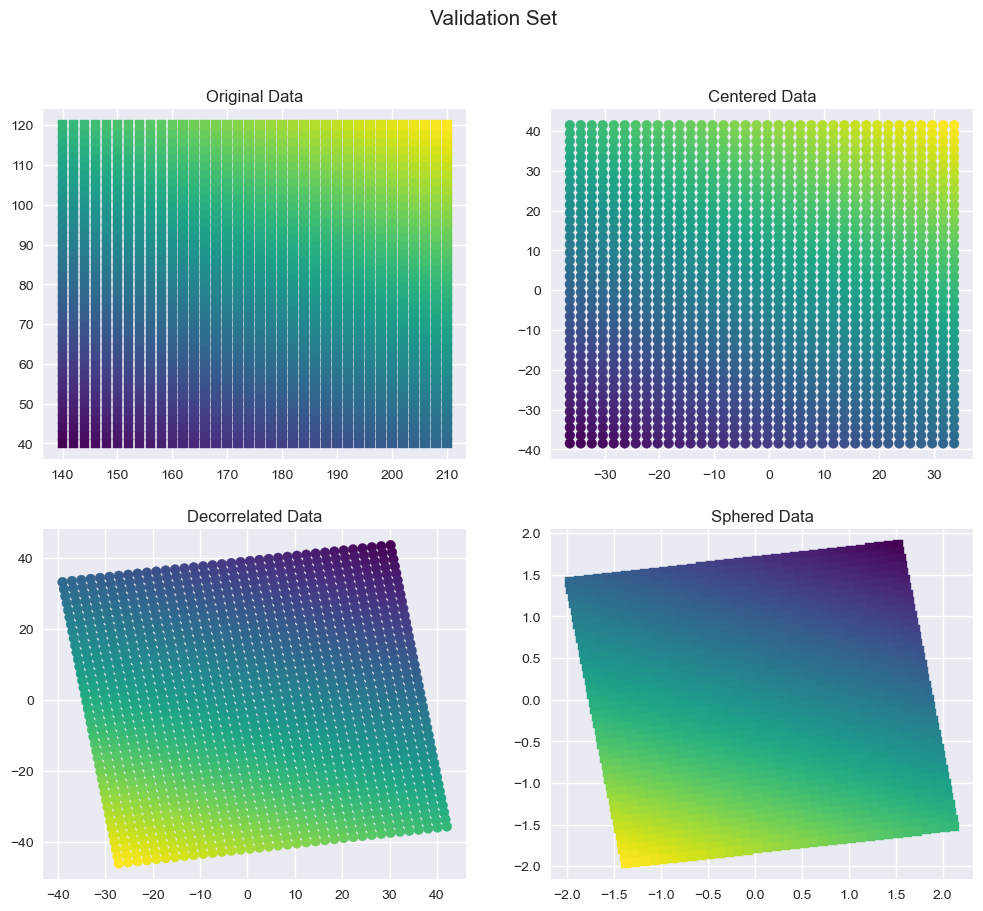

x_test_sphered mean: [ 0. -0.]
x_test_sphered std: [1. 1.]


In [7]:
# Plot of the data
plt.style.use('seaborn')

fig = plt.figure(figsize=(12,10))
fig.suptitle('Validation Set', fontsize=15)

#Original data
ax1 = fig.add_subplot(221)
ax1.scatter(x_validate[:,0], x_validate[:,1], c=y_pred, marker = 's' ,cmap='viridis')
ax1.title.set_text('Original Data')

#Centered data
ax2 = fig.add_subplot(222)  
ax2.scatter(x_test_center[:,0], x_test_center[:,1], c=y_pred, cmap='viridis')
ax2.title.set_text('Centered Data')

#Decorrelated data
ax3 = fig.add_subplot(223)  
ax3.scatter(x_test_decorrelate[0,:], x_test_decorrelate[1,:], c=y_pred, cmap='viridis') 
ax3.title.set_text('Decorrelated Data')

#Whitened data
ax4 = fig.add_subplot(224) 
ax4.scatter(x_test_sphere[0,:], x_test_sphere[1,:], marker = 's',c=y_pred, cmap='viridis')
ax4.title.set_text('Sphered Data')

plt.show()

#properties of the data after whitening/sphering
print(f'x_test_sphered mean: {np.round(np.mean(x_test_sphere, axis=1))}')
print(f'x_test_sphered std: {np.round(np.std(x_test_sphere, axis=1))}')

##### Teil B
Feature Expansion: A single linear neuron is not able to predict the target labels very well. To increase the representational power of the model class, expand the sphered 2D input to all possible monomials up to degree 9.
Here, a monomial of order k corresponds to a term x1^lx2^m with l + m = k.
The model should contain all 55 terms x1^lx2^m with l + m = k for k = 0, 1, ..., 9. These
monomials can be enumerated by i = 1, . . . , d = 55 defining φi(x). The prediction function
which feeds into the quadratic cost measure ET is given by


/var/folders/qg/bvmbx8kx66v9dn0hmz5f07780000gq/T/ipykernel_17502/3882660611.py:29: RuntimeWarning: divide by zero encountered in true_divide
  λ = np.diag(1/np.sqrt(λ))
/var/folders/qg/bvmbx8kx66v9dn0hmz5f07780000gq/T/ipykernel_17502/3882660611.py:36: RuntimeWarning: invalid value encountered in matmul
  x_sphered = λ@x_decorrelated
/var/folders/qg/bvmbx8kx66v9dn0hmz5f07780000gq/T/ipykernel_17502/3882660611.py:29: RuntimeWarning: divide by zero encountered in true_divide
  λ = np.diag(1/np.sqrt(λ))
/var/folders/qg/bvmbx8kx66v9dn0hmz5f07780000gq/T/ipykernel_17502/3882660611.py:36: RuntimeWarning: invalid value encountered in matmul
  x_sphered = λ@x_decorrelated
/var/folders/qg/bvmbx8kx66v9dn0hmz5f07780000gq/T/ipykernel_17502/3882660611.py:29: RuntimeWarning: divide by zero encountered in true_divide
  λ = np.diag(1/np.sqrt(λ))
/var/folders/qg/bvmbx8kx66v9dn0hmz5f07780000gq/T/ipykernel_17502/3882660611.py:36: RuntimeWarning: invalid value encountered in matmul
  x_sphered = λ@x_decorrel

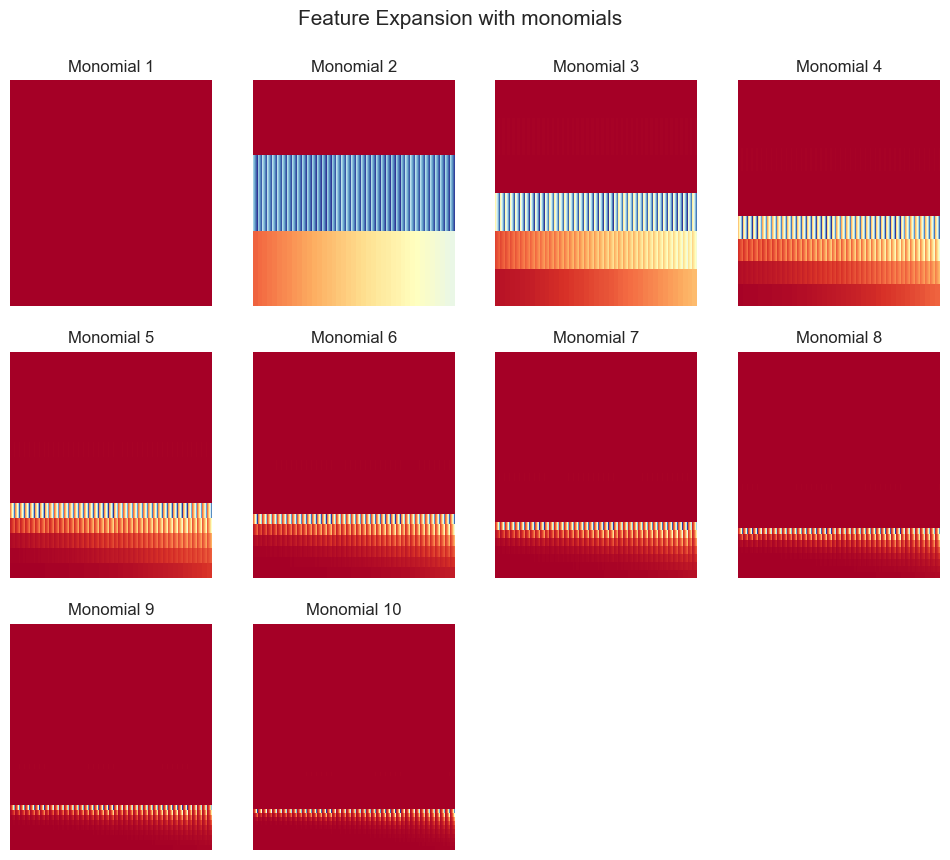

In [72]:
# demonstrate the types of features created
from numpy import asarray
from sklearn.preprocessing import PolynomialFeatures

# define dataset
data_validate = np.genfromtxt('Data/ValidationRidge.csv', delimiter=',',dtype=float, skip_header=1)
x_validate = data_validate[:,0:2]
yT = data_validate[:,2]

fig = plt.figure(figsize=(12,10))
fig.suptitle('Feature Expansion with monomials', fontsize=15, y=0.95)
for i in range(10):
    #Performing the polynomial transformation
    poly = PolynomialFeatures(degree=i)
    x_poly = poly.fit_transform(x_validate).T #transposing the data to get the correct shape
    # print(f'x_poly {i}: {x_poly.shape}')
    
    #centering the data
    x_poly_center = x_poly - np.mean(x_poly, axis=1).reshape(-1,1)
    
    #decorrelating the data
    C = np.cov(x_poly_center)
    
    if i == 0:
        E=0 
    else:
       λ,E = np.linalg.eig(C)
       #diagonal matrix of eigenvalues
       λ = np.diag(1/np.sqrt(λ))
       λ = λ.real.round(4)
       
       # #Decorrelate the data
       x_decorrelated = E.T@x_poly_center
       
       # #Whitening the data
       x_sphered = λ@x_decorrelated
       
       
    
    ax = fig.add_subplot(3,4,i+1)
    ax = sns.heatmap(x_poly, cmap='RdYlBu', cbar=False, xticklabels=False, yticklabels=False)
    ax.title.set_text(f'Monomial {i+1}')
       
    
    
    w= np.linalg.inv(x_poly @ x_poly.T) @ x_poly @ yT.T
    y_predicted = w.T @ x_poly
    



